<a href="https://colab.research.google.com/github/SurawutK/Kaggle-Projects/blob/main/housing-prices-predictions-xgb/house_prices_prediction_using_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

title: "House Prices - Regression Problem"
author: "Surawut Kittikaiwan"
date: "2024-04-24"

---

# 1. Frame the problem

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Data Extraction

For this problem, 3 datasets with 79 attributes that include information for every aspect of residential homes in Ames, Iowa. The dataset description of each attribute is also provided.

* `train.csv` : the training set
* `test.csv` : the test set
* `sample_submission.csv` : a benchmark submission from a linear regression on year and month of sale, lot square footage, and number of bedrooms

* `data_description.txt` : full description of each column, originally prepared by Dean De Cock but lightly edited to match the column names used here

In [2]:
train_set = pd.read_csv('http://raw.githubusercontent.com/SurawutK/Kaggle-Projects/refs/heads/main/datasets/house-prices/train.csv')

In [3]:
test_set_submit = pd.read_csv('https://raw.githubusercontent.com/SurawutK/Kaggle-Projects/refs/heads/main/datasets/house-prices/test.csv')

## 2-1 Take a Quick Look at the Data Structure

In [4]:
# Training set
display(train_set.head())
print(f'Training set consist of {train_set.shape[0]} instances with {train_set.shape[1]-1} input features, and 1 label.')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Training set consist of 1460 instances with 80 input features, and 1 label.


In [5]:
# Test set
display(test_set_submit.head())
print(f'Test set consist of {test_set_submit.shape[0]} instances with {test_set_submit.shape[1]} input features.')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Test set consist of 1459 instances with 80 input features.


In [6]:
# Explore statistical values for numerical attributes
train_set.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
# Explore statistical values for object attributes
train_set.describe(include=['object'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


## 2-2 Split Data into Train set and Validation (dev) set

To avoid sampling bias and ensure that test set is representative of the ovarall population, stratified sampling will be used for splitting training data set into `train set` and `test set`. The population is divided into homogeneous subgroups called strata, and the right number of instances are sampled from each stratum.

For this dataset, I want to ensure that the test set is representative of the various categories of ages in the whole dataset.

In [8]:
# Explore some features that might be able to represent the population
train_set[['YearBuilt', 'YearRemodAdd', 'YrSold', 'MoSold']].head()

,YearBuilt,YearRemodAdd,YrSold,MoSold
0,2003,2003,2008,2
1,1976,1976,2007,5
2,2001,2002,2008,9
3,1915,1970,2006,2
4,2000,2000,2008,12


In [9]:
# We can create a new feature 'Age' that indicate the age of individual housing
train_set['Age'] = train_set['YrSold'] - train_set['YearBuilt']

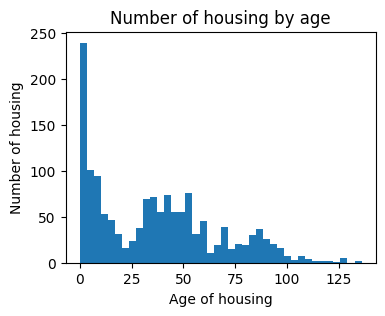

In [10]:
# histrogram of housing's age
train_set['Age'].hist(bins=40, figsize=(4,3))
plt.xlabel('Age of housing')
plt.ylabel('Number of housing')
plt.title('Number of housing by age')
plt.grid()
plt.show()

In [11]:
# Create Age_cat attribute using padas.cut() method
train_set['Age_cat'] = pd.cut(train_set['Age'], bins=[-np.inf, 25., 50., 75., 100., 125., np.inf],
                             precision=1, labels=[1,2,3,4,5,6])
train_set.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Age,Age_cat
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,2,2008,WD,Normal,208500,5,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,5,2007,WD,Normal,181500,31,2
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,9,2008,WD,Normal,223500,7,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,2,2006,WD,Abnorml,140000,91,4
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,12,2008,WD,Normal,250000,8,1


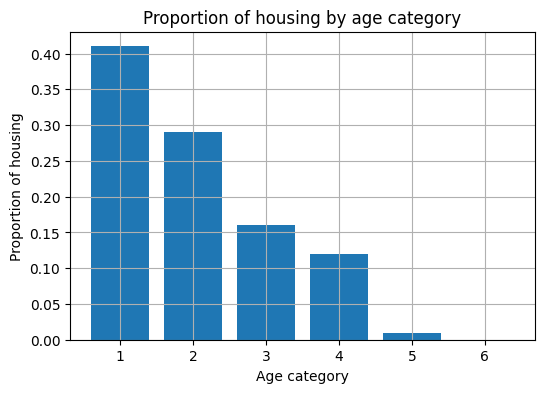

In [12]:
# Create visualization for age categories
age_cat_prop = train_set['Age_cat'].value_counts(sort=False, normalize=True).to_frame().reset_index().round(2)
plt.figure(figsize=(6,4))
plt.bar(data=age_cat_prop, x='Age_cat', height='proportion')
plt.xlabel('Age category')
plt.ylabel('Proportion of housing')
plt.title('Proportion of housing by age category')
plt.grid()
plt.show()

In [13]:
# Splitting the dataset in to train set and dev set using stratifird sampling by age category
from sklearn.model_selection import train_test_split

X = train_set.drop(columns=['Id', 'SalePrice'])
y = train_set['SalePrice'].copy()

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2,
                                    stratify=X['Age_cat'], random_state=42)

In [14]:
# Check proportion of housing by age category
X_train['Age_cat'].value_counts(normalize=True, sort=False)

,proportion
Age_cat,
1,0.405822
2,0.293664
3,0.162671
4,0.118151
5,0.014555
6,0.005137


In [15]:
# drop 'Age_cat' column
for set_ in (X_train, X_dev):
    set_.drop(columns=['Age', 'Age_cat'], inplace=True)

# 3. Explore and Visualize the Data to Gain Insights

In [16]:
# To prevent change in training set, copy the strat_train_set and assign to new variable
housing = X_train.copy()

In [17]:
# Explore first 5 rows
housing.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
914,160,FV,30.0,3000,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2009,New,Partial
252,60,RL,65.0,8366,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
481,20,RL,72.0,11846,Pave,NaN,IR1,HLS,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2006,WD,Normal
1087,60,FV,85.0,10574,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal
71,20,RL,69.0,7599,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal


In [18]:
# data dictionary
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 914 to 862
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1168 non-null   int64  
 1   MSZoning       1168 non-null   object 
 2   LotFrontage    953 non-null    float64
 3   LotArea        1168 non-null   int64  
 4   Street         1168 non-null   object 
 5   Alley          65 non-null     object 
 6   LotShape       1168 non-null   object 
 7   LandContour    1168 non-null   object 
 8   Utilities      1168 non-null   object 
 9   LotConfig      1168 non-null   object 
 10  LandSlope      1168 non-null   object 
 11  Neighborhood   1168 non-null   object 
 12  Condition1     1168 non-null   object 
 13  Condition2     1168 non-null   object 
 14  BldgType       1168 non-null   object 
 15  HouseStyle     1168 non-null   object 
 16  OverallQual    1168 non-null   int64  
 17  OverallCond    1168 non-null   int64  
 18  YearBuilt   

## 3-1 Visualizing Data

In [19]:
housing.dtypes.value_counts()

,count
object,43
int64,33
float64,3


In [20]:
# Create a list to collect numerical features and categorical features
numeric_cols = X_train.select_dtypes(include=['int', 'float']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print(f'Numeric {len(numeric_cols)} columns:\n{numeric_cols}')
print(f'\nCategorical {len(categorical_cols)} columns:\n{categorical_cols}')

print(f'Number of numerical features: {len(numeric_cols)}\nNumber of categorical features: {len(categorical_cols)}')

Numeric 36 columns:
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

Categorical 43 columns:
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageTy

In [21]:
# data dictionary for numerical attributes
housing[numeric_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 914 to 862
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1168 non-null   int64  
 1   LotFrontage    953 non-null    float64
 2   LotArea        1168 non-null   int64  
 3   OverallQual    1168 non-null   int64  
 4   OverallCond    1168 non-null   int64  
 5   YearBuilt      1168 non-null   int64  
 6   YearRemodAdd   1168 non-null   int64  
 7   MasVnrArea     1162 non-null   float64
 8   BsmtFinSF1     1168 non-null   int64  
 9   BsmtFinSF2     1168 non-null   int64  
 10  BsmtUnfSF      1168 non-null   int64  
 11  TotalBsmtSF    1168 non-null   int64  
 12  1stFlrSF       1168 non-null   int64  
 13  2ndFlrSF       1168 non-null   int64  
 14  LowQualFinSF   1168 non-null   int64  
 15  GrLivArea      1168 non-null   int64  
 16  BsmtFullBath   1168 non-null   int64  
 17  BsmtHalfBath   1168 non-null   int64  
 18  FullBath    

In [22]:
# data dictionary for categorical features
housing[categorical_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 914 to 862
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1168 non-null   object
 1   Street         1168 non-null   object
 2   Alley          65 non-null     object
 3   LotShape       1168 non-null   object
 4   LandContour    1168 non-null   object
 5   Utilities      1168 non-null   object
 6   LotConfig      1168 non-null   object
 7   LandSlope      1168 non-null   object
 8   Neighborhood   1168 non-null   object
 9   Condition1     1168 non-null   object
 10  Condition2     1168 non-null   object
 11  BldgType       1168 non-null   object
 12  HouseStyle     1168 non-null   object
 13  RoofStyle      1168 non-null   object
 14  RoofMatl       1168 non-null   object
 15  Exterior1st    1168 non-null   object
 16  Exterior2nd    1168 non-null   object
 17  MasVnrType     461 non-null    object
 18  ExterQual      1168 non-null   o

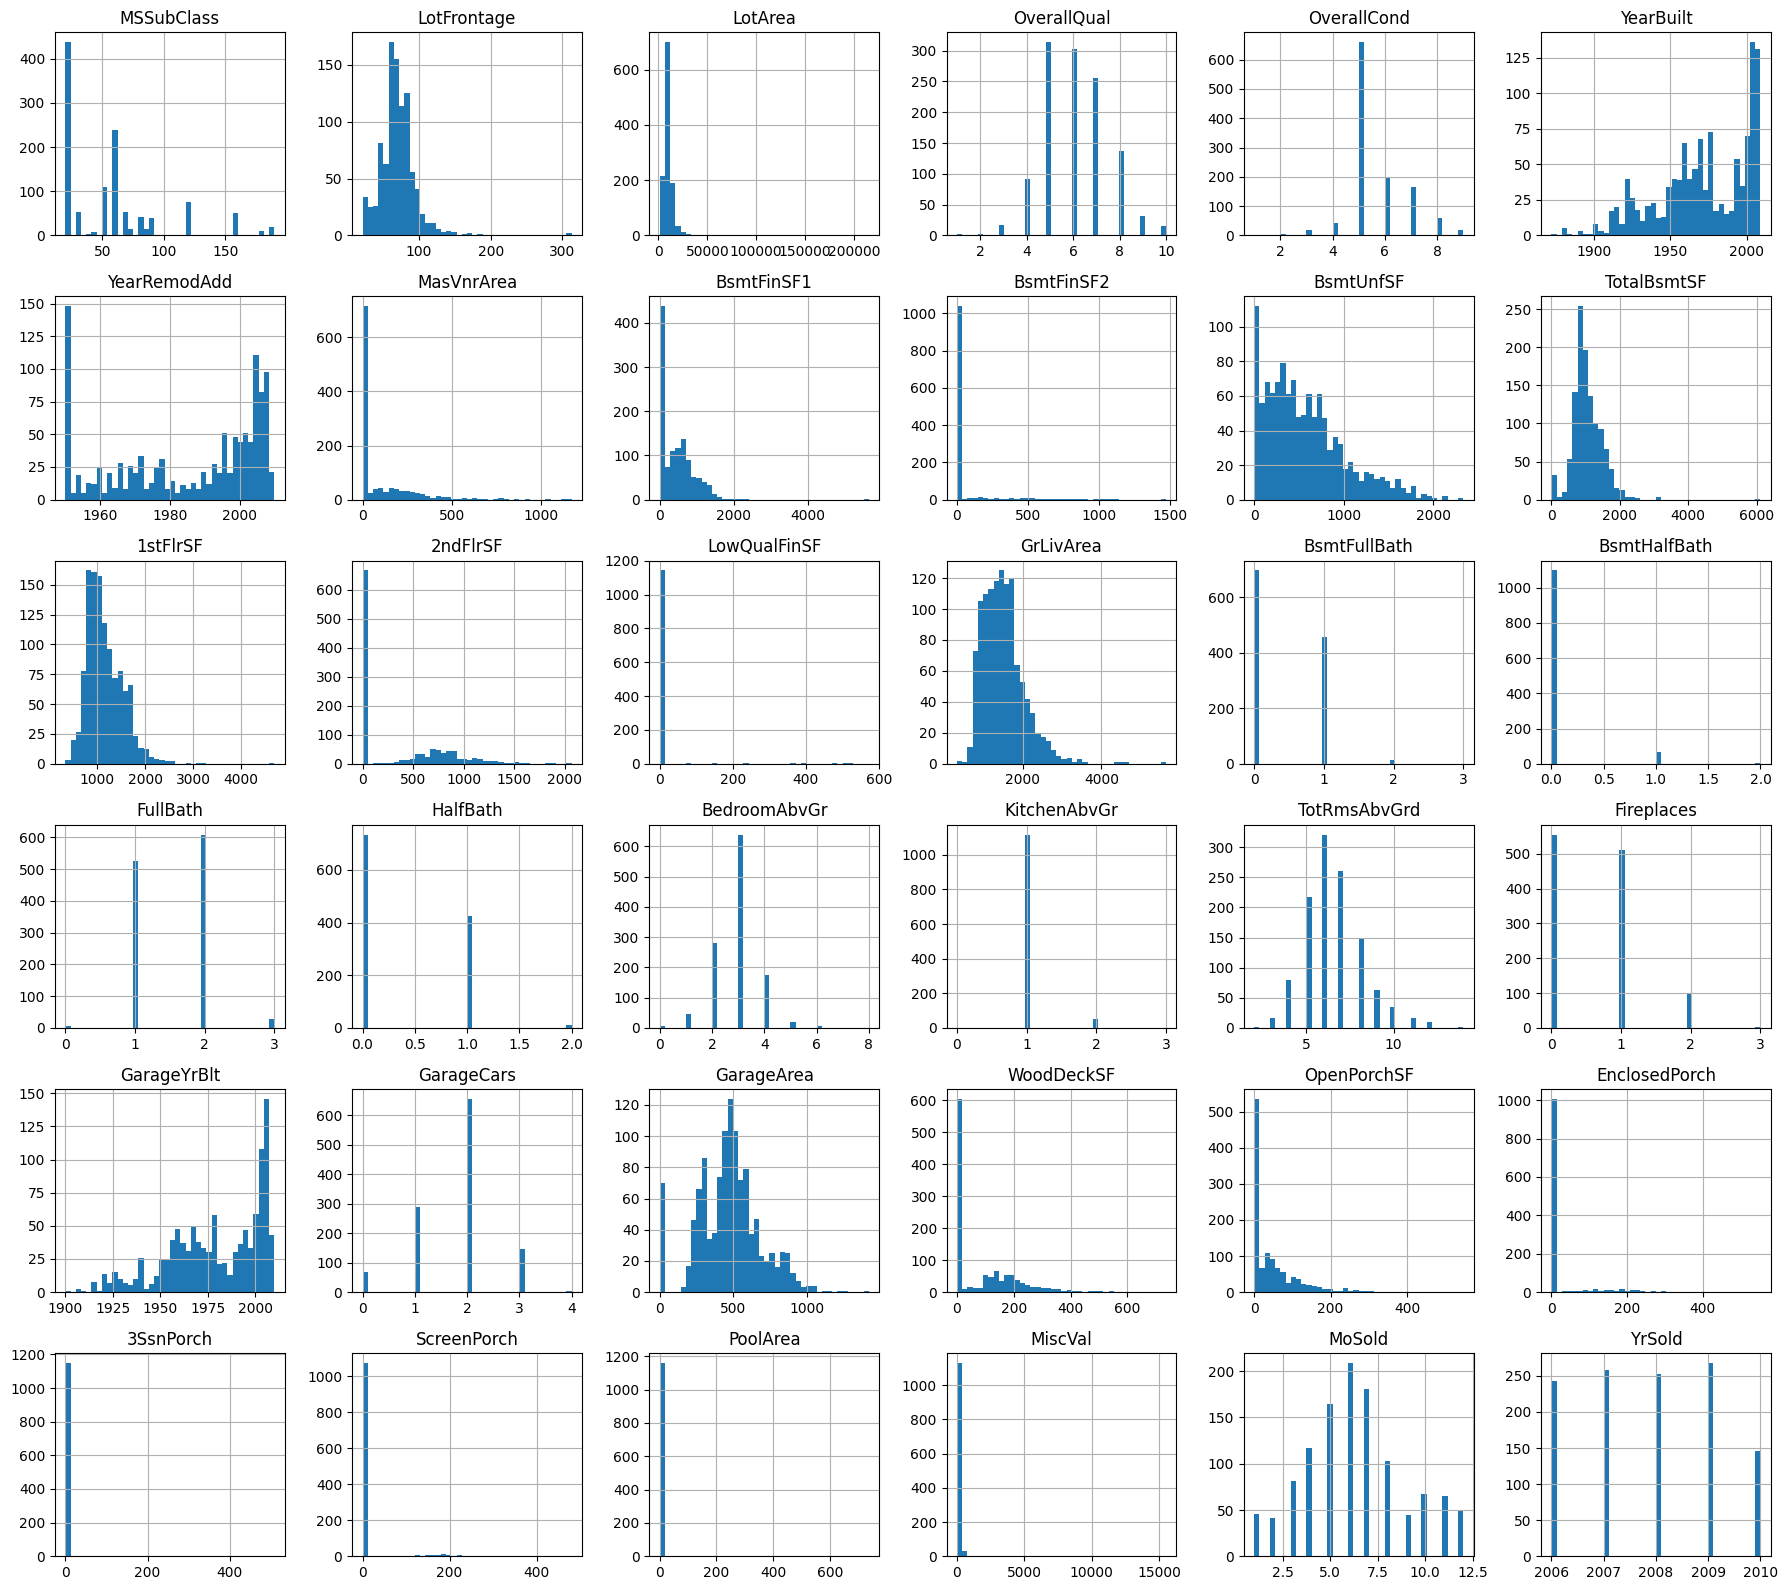

In [23]:
# Plot histrogram for each numerical attributes
housing[numeric_cols].hist(bins=40, figsize=(18,16))
plt.tight_layout()
plt.show()

## 3-2 Look for Correlations

In [24]:
# correlation matrix of all numeric attributes
corr_matrix = housing[numeric_cols].corr()
corr_matrix

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
MSSubClass,1.000000,-0.388673,-0.205085,0.059542,-0.049985,0.050554,0.072687,0.028285,-0.082748,-0.080172,...,-0.114750,-0.013451,0.007341,-0.007995,-0.038593,-0.004042,0.010063,-0.019231,0.005755,-0.025855
LotFrontage,-0.388673,1.000000,0.421817,0.229234,-0.037550,0.101812,0.089619,0.202631,0.248052,0.059786,...,0.325554,0.079664,0.142831,0.005394,0.064490,0.035912,0.225900,0.004888,-0.001106,0.017218
LotArea,-0.205085,0.421817,1.000000,0.114286,0.009053,0.005819,0.022807,0.126164,0.205063,0.137007,...,0.173096,0.091610,0.097632,-0.009680,0.020145,0.060299,0.093758,0.019010,-0.008847,0.005145
OverallQual,0.059542,0.229234,0.114286,1.000000,-0.081476,0.554241,0.551378,0.411238,0.238675,-0.051502,...,0.564214,0.238930,0.288258,-0.097562,0.027616,0.072334,0.072663,-0.022484,0.079687,-0.042945
OverallCond,-0.049985,-0.037550,0.009053,-0.081476,1.000000,-0.375377,0.084132,-0.113169,-0.039348,0.033480,...,-0.130339,0.005274,-0.025305,0.065096,0.024210,0.048135,-0.002957,0.069371,0.005264,0.038996
YearBuilt,0.050554,0.101812,0.005819,0.554241,-0.375377,1.000000,0.596534,0.305102,0.258943,-0.045908,...,0.476524,0.225890,0.162075,-0.379806,0.032049,-0.047770,0.005326,-0.033352,0.014069,-0.013711
YearRemodAdd,0.072687,0.089619,0.022807,0.551378,0.084132,0.596534,1.000000,0.169533,0.148590,-0.056946,...,0.379254,0.221445,0.209182,-0.179320,0.043451,-0.044382,0.005820,-0.005951,0.027388,0.021629
MasVnrArea,0.028285,0.202631,0.126164,0.411238,-0.113169,0.305102,0.169533,1.000000,0.286176,-0.057305,...,0.379140,0.161012,0.130555,-0.104075,0.029417,0.055289,0.016309,-0.018320,0.010395,-0.013947
BsmtFinSF1,-0.082748,0.248052,0.205063,0.238675,-0.039348,0.258943,0.148590,0.286176,1.000000,-0.044271,...,0.293293,0.178740,0.115892,-0.092992,0.023264,0.090902,0.156045,0.001179,-0.011208,0.020633
BsmtFinSF2,-0.080172,0.059786,0.137007,-0.051502,0.033480,-0.045908,-0.056946,-0.057305,-0.044271,1.000000,...,-0.012952,0.076102,0.002842,0.031528,-0.032280,0.099756,0.043970,-0.009655,-0.022613,0.033286


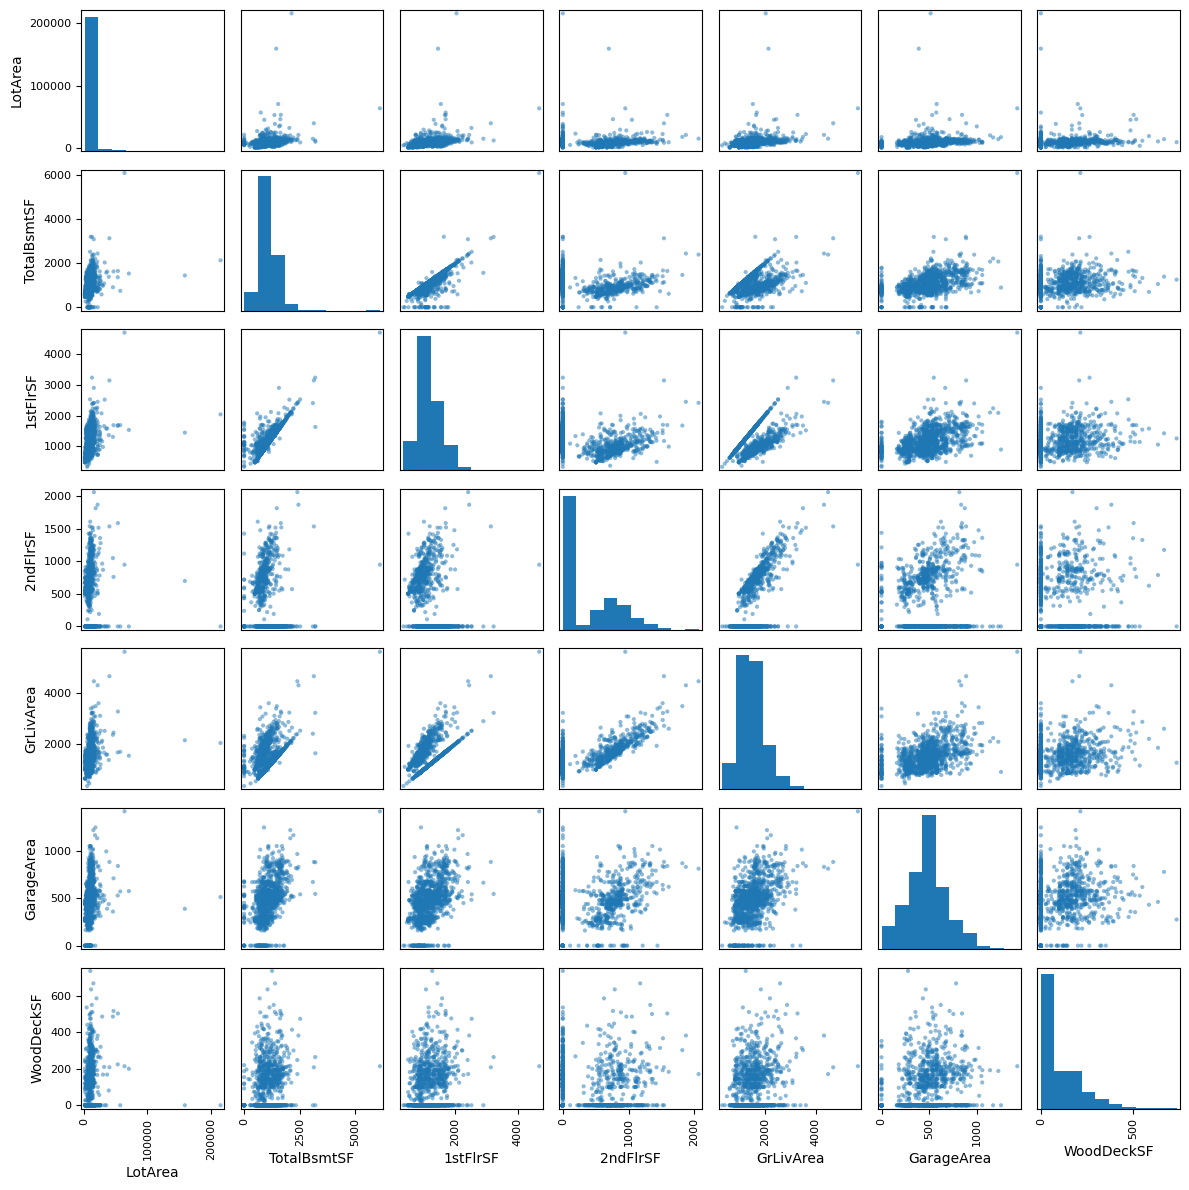

In [25]:
# Scatter matrix: Create the scatter plots for some numeric attributes
from pandas.plotting import scatter_matrix

attributes = ['LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
              'GrLivArea', 'GarageArea', 'WoodDeckSF']
scatter_matrix(housing[attributes], figsize=(12, 12))
plt.tight_layout()
plt.show()

# 4. Data Preparation

In [26]:
# Seperate the fetures and the labels, and create a copy of training set
housing = X_train.copy()
housing_labels = y.copy()

In [27]:
housing.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
914,160,FV,30.0,3000,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2009,New,Partial
252,60,RL,65.0,8366,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
481,20,RL,72.0,11846,Pave,NaN,IR1,HLS,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2006,WD,Normal
1087,60,FV,85.0,10574,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal
71,20,RL,69.0,7599,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal


## 4-1 Data Cleaning

### *Missing Values*

In [28]:
col_with_null = [col for col in housing.columns if np.sum(housing[col].isnull()) != 0]
housing[col_with_null].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 914 to 862
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   953 non-null    float64
 1   Alley         65 non-null     object 
 2   MasVnrType    461 non-null    object 
 3   MasVnrArea    1162 non-null   float64
 4   BsmtQual      1137 non-null   object 
 5   BsmtCond      1137 non-null   object 
 6   BsmtExposure  1137 non-null   object 
 7   BsmtFinType1  1137 non-null   object 
 8   BsmtFinType2  1136 non-null   object 
 9   FireplaceQu   613 non-null    object 
 10  GarageType    1098 non-null   object 
 11  GarageYrBlt   1098 non-null   float64
 12  GarageFinish  1098 non-null   object 
 13  GarageQual    1098 non-null   object 
 14  GarageCond    1098 non-null   object 
 15  PoolQC        7 non-null      object 
 16  Fence         228 non-null    object 
 17  MiscFeature   41 non-null     object 
dtypes: float64(3), object(15)
memory

### *- LotFrontage*

In [29]:
housing.loc[housing['LotFrontage'].isna(), :]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1260,60,RL,NaN,24682,Pave,NaN,IR3,Lvl,AllPub,CulDSac,...,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal
1161,20,RL,NaN,14778,Pave,NaN,IR1,Low,AllPub,CulDSac,...,0,0,NaN,NaN,NaN,0,11,2008,WD,Normal
1154,60,RL,NaN,13700,Pave,NaN,IR1,Lvl,AllPub,Inside,...,273,0,NaN,GdPrv,NaN,0,5,2008,WD,Normal
868,60,RL,NaN,14762,Pave,NaN,IR2,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal
917,20,RL,NaN,17140,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2009,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2009,WD,Normal
1146,20,RL,NaN,11200,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal
593,120,RM,NaN,4435,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal
770,85,RL,NaN,7252,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,0,NaN,NaN,NaN,0,4,2009,WD,Normal


In [30]:
corr_matrix['LotFrontage']

,LotFrontage
MSSubClass,-0.388673
LotFrontage,1.000000
LotArea,0.421817
OverallQual,0.229234
OverallCond,-0.037550
YearBuilt,0.101812
YearRemodAdd,0.089619
MasVnrArea,0.202631
BsmtFinSF1,0.248052
BsmtFinSF2,0.059786


In [31]:
housing['LotArea'].describe()

,LotArea
count,1168.000000
mean,10390.295377
std,9354.844096
min,1300.000000
25%,7500.000000
50%,9478.500000
75%,11600.000000
max,215245.000000


In [32]:
housing['LotArea_cat'] = pd.cut(housing['LotArea'], bins=[0., 2000., 4000., 6000., 8000., 10000., 12000., 14000., 16000., 18000., np.inf],
                                precision=1, labels=np.arange(1, 11, 1))
housing['LotArea_cat'].value_counts()

,count
LotArea_cat,
5,323
6,240
4,179
7,115
3,96
2,56
8,53
10,53
9,31


In [33]:
housing.groupby('LotArea_cat', observed=False)['LotFrontage'].median()

,LotFrontage
LotArea_cat,
1,21.0
2,35.0
3,50.0
4,60.0
5,70.0
6,79.0
7,85.0
8,90.0
9,80.0


In [34]:
housing.groupby('LotArea_cat', observed=False)['LotFrontage'].transform('median')

,LotFrontage
914,35.0
252,70.0
481,79.0
1087,79.0
71,60.0
...,...
633,70.0
55,79.0
455,70.0
33,79.0


In [35]:
LotFrontage_median = housing.groupby('LotArea_cat', observed=False)['LotFrontage'].transform('median')
housing.fillna({'LotFrontage': LotFrontage_median}, inplace=True)

### *- MasVnrArea*

In [36]:
housing.loc[(housing['MasVnrType'].isna()) & (housing['MasVnrArea'] != 0.), ['MasVnrType', 'MasVnrArea']]

,MasVnrType,MasVnrArea
529,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
624,NaN,288.0
650,NaN,NaN
1300,NaN,344.0
973,NaN,NaN
936,NaN,NaN
773,NaN,1.0


In [37]:
housing.fillna({'MasVnrArea': 0.}, inplace=True)

### *- GarageYrBlt*

In [38]:
housing.loc[housing['GarageYrBlt'].isna(), ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']]

,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond
1234,NaN,NaN,NaN,NaN,NaN
535,NaN,NaN,NaN,NaN,NaN
127,NaN,NaN,NaN,NaN,NaN
434,NaN,NaN,NaN,NaN,NaN
198,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
976,NaN,NaN,NaN,NaN,NaN
1173,NaN,NaN,NaN,NaN,NaN
1283,NaN,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN,NaN


In [39]:
housing.fillna({'GarageYrBlt': -999.}, inplace=True)

### *- Other Categorical Attributes*

In [40]:
housing.fillna({'Alley': 'No alley access',
               'MasVnrType': 'None',
               'BsmtQual': 'No Basement',
               'BsmtCond': 'No Basement',
               'BsmtExposure': 'No Basement',
               'BsmtFinType1': 'No Basement',
               'BsmtFinType2': 'No Basement',
               'FireplaceQu': 'No Fireplace',
               'GarageType': 'No Garage',
               'GarageFinish': 'No Garage',
               'GarageQual': 'No Garage',
               'GarageCond': 'No Garage',
               'PoolQC': 'No Pool',
               'Fence': 'No Fence',
               'MiscFeature': 'None'}, inplace=True)

In [41]:
housing

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotArea_cat
914,160,FV,30.0,3000,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,No Pool,No Fence,None,0,6,2009,New,Partial,2
252,60,RL,65.0,8366,Pave,No alley access,IR1,Lvl,AllPub,Inside,...,0,No Pool,No Fence,None,0,12,2008,WD,Normal,5
481,20,RL,72.0,11846,Pave,No alley access,IR1,HLS,AllPub,Inside,...,0,No Pool,No Fence,None,0,8,2006,WD,Normal,6
1087,60,FV,85.0,10574,Pave,No alley access,Reg,Lvl,AllPub,Inside,...,0,No Pool,No Fence,None,0,5,2009,WD,Normal,6
71,20,RL,69.0,7599,Pave,No alley access,Reg,Lvl,AllPub,Corner,...,0,No Pool,No Fence,None,0,6,2007,WD,Normal,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,20,RL,80.0,9250,Pave,No alley access,Reg,Lvl,AllPub,Corner,...,0,No Pool,No Fence,None,0,7,2007,WD,Normal,5
55,20,RL,100.0,10175,Pave,No alley access,IR1,Lvl,AllPub,Inside,...,0,No Pool,No Fence,None,0,7,2008,WD,Normal,6
455,20,RL,80.0,9600,Pave,No alley access,Reg,Lvl,AllPub,Inside,...,0,No Pool,No Fence,None,0,9,2007,WD,Normal,5
33,20,RL,70.0,10552,Pave,No alley access,IR1,Lvl,AllPub,Inside,...,0,No Pool,No Fence,None,0,4,2010,WD,Normal,6


### Dropping Duplicates

In [42]:
# Dropping duplicate rows (if found)
housing.drop_duplicates(inplace=True)

## 4-2 Construct Transformation Pipelines

In [43]:
print(f'Numeric cols: {numeric_cols}\nlength: {len(numeric_cols)}\n')
print(f'Categorical cols: {categorical_cols}\nlength: {len(categorical_cols)}')

Numeric cols: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
length: 36

Categorical cols: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageTyp

In [44]:
# Making a single pipeline that will perform all the transformations I've experimented with up to now

# modules for making pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# modules for preprocessing data
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Drop any columns with missing values > 30% in training set (X_train)
min_non_na = int(0.7 * len(X_train))
new_numeric_cols = X_train[numeric_cols].dropna(axis=1, thresh=min_non_na).columns.tolist()
new_categorical_cols = X_train[categorical_cols].dropna(axis=1, thresh=min_non_na).columns.tolist()

# Build pipelines and column transformer
numeric_pipeline = Pipeline(
    [
        ('numeric_imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

categorical_pipeline = Pipeline(
    [
        ('categorical_imputer', SimpleImputer(strategy='most_frequent')),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]
)

preprocessing_pipeline = ColumnTransformer(
    [
        ('numeric_preprocess', numeric_pipeline, new_numeric_cols),
        ('categorical_preprocess', categorical_pipeline, new_categorical_cols)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

from sklearn import set_config
set_config(display='diagram')

In [45]:
# Test preprocessing pipeline
X_train_cleaned = preprocessing_pipeline.fit_transform(X_train)
X_train_cleaned = pd.DataFrame(
                        X_train_cleaned,
                        index=X_train.index,
                        columns=preprocessing_pipeline.get_feature_names_out()
                    )

X_train_cleaned

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
914,2.470772,-1.774225,-0.790335,-0.074933,-0.521483,1.245174,1.158358,-0.131670,-0.313131,-0.288286,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
252,0.083296,-0.216978,-0.216483,-0.074933,-0.521483,1.079822,0.916515,-0.582180,-0.949890,-0.288286,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
481,-0.871694,0.094471,0.155676,2.095020,-0.521483,1.046752,0.916515,2.749225,2.443989,-0.288286,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1087,0.083296,0.672877,0.019646,1.371703,-0.521483,1.112893,1.013252,-0.582180,-0.949890,-0.288286,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
71,-0.871694,-0.039007,-0.298507,-1.521568,0.367702,0.352277,1.013252,-0.582180,0.273812,-0.288286,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,-0.871694,0.450413,-0.121946,-0.798250,1.256887,-0.573689,0.964884,-0.582180,0.089716,2.499230,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
55,-0.871694,1.340268,-0.023024,-0.074933,-0.521483,-0.242987,-1.018222,1.030173,0.111374,-0.288286,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
455,-0.871694,0.450413,-0.084516,0.648385,0.367702,0.054645,-0.582906,1.314706,1.034024,-0.288286,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
33,-0.871694,0.005485,0.017293,-0.798250,-0.521483,-0.408338,-1.260064,-0.582180,1.254940,-0.288286,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [46]:
preprocessing_pipeline

ColumnTransformer(transformers=[('numeric_preprocess',
                                 Pipeline(steps=[('numeric_imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['MSSubClass', 'LotFrontage', 'LotArea',
                                  'OverallQual', 'OverallCond', 'YearBuilt',
                                  'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
                                  'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                                  '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                                  'G...
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'Neighborhood', 'Condition1',
                                  'Condition2', 'BldgType', 'HouseStyle',
                                  'RoofStyle', 'RoofMatl', 'Exterior1st',
                                  'Exterior2nd', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'Functional', ...])],
                  verbose_feature_names_out=False)

# 5. Build and Evaluate Models

* Ridge Regression (baseline model)
* XGBoost Regression

## 5.1 Ridge Regression (baseline model)

In [47]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

ridge_model = make_pipeline(
    preprocessing_pipeline,
    Ridge(random_state=42)
)

ridge_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric_preprocess',
                                                  Pipeline(steps=[('numeric_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1...
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'Functional', ...])],
                                   verbose_feature_names_out=False)),
                ('ridge', Ridge(random_state=42))])

In [48]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning,
                        module='sklearn.preprocessing._encoders')

In [49]:
from sklearn.metrics import mean_squared_log_error as MSLE

def evaluate_rmsle(model, X_train, y_train, X_dev, y_dev):
    y_train_pred = model.predict(X_train)
    train_msle = MSLE(y_true=y_train, y_pred=y_train_pred)
    train_rmsle = np.sqrt(train_msle)
    print(f'Train RMSLE: {train_rmsle:.6f}')

    y_dev_pred = model.predict(X_dev)
    dev_msle = MSLE(y_true=y_dev, y_pred=y_dev_pred)
    dev_rmsle = np.sqrt(dev_msle)
    print(f'Development RMSLE: {dev_rmsle:.6f}')

evaluate_rmsle(ridge_model, X_train, y_train, X_dev, y_dev)

Train RMSLE: 0.116882
Development RMSLE: 0.140171


In [50]:
from sklearn.model_selection import KFold, cross_val_score

def kfold_cross_validate(model, X, y, n_splits=5, scoring='neg_mean_squared_log_error'):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_msle = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    print(f'Cross-Validation RMSLE: {np.sqrt(np.abs(cv_msle))}')
    print(f'Mean RMSLE: {np.sqrt(np.abs(cv_msle.mean())):.6f}')

kfold_cross_validate(ridge_model, X, y)

Cross-Validation RMSLE: [0.15646588 0.15234622 0.19496071 0.18724235 0.13179588]
Mean RMSLE: 0.166211


## 5.2 XGBoost Regression

In [51]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error as MSLE


xgb_model = Pipeline(
    [
        ('prep', preprocessing_pipeline),
        ('model', xgb.XGBRegressor(
                    objective='reg:squarederror',
                    eval_metric=MSLE,
                    random_state=42,
                    n_jobs=-1))
    ]
)

xgb_model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric_preprocess',
                                                  Pipeline(steps=[('numeric_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2nd...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [52]:
# Evaluate data on train and validation set
evaluate_rmsle(xgb_model, X_train, y_train, X_dev, y_dev)

Train RMSLE: 0.008603
Development RMSLE: 0.128170


In [53]:
# Kfold cross-validation
kfold_cross_validate(xgb_model, X, y)

Cross-Validation RMSLE: [0.14884235 0.12535071 0.16967565 0.14459554 0.12156443]
Mean RMSLE: 0.143068


In [54]:
# Hyperparameters tunning
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import uniform, loguniform, randint

param_dists = [
    {
        # n_estimators:
        'model__n_estimators': randint(100, 300),

        # learning_rate:
        'model__learning_rate': loguniform(0.01, 0.3),

        # max_depth:
        'model__max_depth': randint(3, 10),

        # min_child_weight:
        'model__min_child_weight': loguniform(1.0, 10.0),

        # subsample:
        'model__subsample': loguniform(0.5, 1.0),

        # colsample_bytree:
        'model__colsample_bytree': loguniform(0.5, 1.0),

        # reg_alpha:
        'model__reg_alpha': loguniform(1, 10),

        # reg_lambda:
        'model__reg_lambda': loguniform(1, 10)
    }
]

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
rand_search_xgb = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dists,
    n_iter=100,
    cv=kfold,
    scoring='neg_mean_squared_log_error',
    refit='neg_mean_squared_log_error',
    n_jobs=-1,
    random_state=42,
    verbose=True
)

rand_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric_preprocess',
                                                                               Pipeline(steps=[('numeric_imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['MSSubClass',
                                                                                'LotFrontage',
                                                                                'LotArea',
                                                                                'OverallQual',
                                                                                'OverallCond',
                                                                                'YearBuilt',
                                                                                'YearRemodAdd',
                                                                                '...
                                         'model__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x787f49de9a50>,
                                         'model__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x787f49de9010>,
                                         'model__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x787f4d4c5b90>}],
                   random_state=42, refit='neg_mean_squared_log_error',
                   scoring='neg_mean_squared_log_error', verbose=True)

In [55]:
# Print results
cv_results_xgb = pd.DataFrame(rand_search_xgb.cv_results_)

# view columns
view_cols = [
    'rank_test_score',
    'mean_test_score',
    'param_model__n_estimators',
    'param_model__learning_rate',
    'param_model__max_depth',
    'param_model__reg_alpha',
    'param_model__reg_lambda'
]

# Top 10 models and their set of hyperparameters with the lowest RMSE
cv_results_xgb.sort_values(by='mean_test_score', ascending=False)[view_cols].iloc[:10]

,rank_test_score,mean_test_score,param_model__n_estimators,param_model__learning_rate,param_model__max_depth,param_model__reg_alpha,param_model__reg_lambda
85,1,-0.017358,146,0.104664,3,4.245222,1.207144
99,2,-0.017770,242,0.101546,3,2.961940,2.581314
78,3,-0.017965,265,0.087986,5,4.142511,9.560106
57,4,-0.018104,227,0.033438,6,3.037533,3.111900
56,5,-0.018175,286,0.055760,3,1.258882,1.131059
63,6,-0.018327,294,0.023302,5,1.793421,2.542155
98,7,-0.018332,237,0.035107,4,9.771477,2.100651
92,8,-0.018521,158,0.089970,4,9.694273,4.034362
46,9,-0.018538,284,0.023224,5,2.197251,1.235376
60,10,-0.018540,106,0.133304,6,2.667420,1.669462


In [56]:
# get the model with the best set of hyperparameters from random search
tunned_xgb_model = rand_search_xgb.best_estimator_
tunned_xgb_model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric_preprocess',
                                                  Pipeline(steps=[('numeric_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2nd...
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.10466389085986656, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=3, max_leaves=None,
                              min_child_weight=1.236774682002112, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=146, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [57]:
# Evaluate data on train and validation set
evaluate_rmsle(tunned_xgb_model, X_train, y_train, X_dev, y_dev)

Train RMSLE: 0.081523
Development RMSLE: 0.116281


In [58]:
# Kfold cross-validation
kfold_cross_validate(tunned_xgb_model, X, y)

Cross-Validation RMSLE: [0.13292121 0.11391433 0.16976851 0.13311288 0.11026578]
Mean RMSLE: 0.133674


# 6.Make Predictions on Test Set

In [59]:
y_test_pred = tunned_xgb_model.predict(test_set_submit)

pred_df = pd.DataFrame(
    {
        'Id': test_set_submit['Id'],
        'SalePrice': y_test_pred
    }
)
pred_df

,Id,SalePrice
0,1461,114404.312500
1,1462,155698.937500
2,1463,188273.953125
3,1464,195610.078125
4,1465,190508.156250
...,...,...
1454,2915,84094.984375
1455,2916,78436.867188
1456,2917,161453.546875
1457,2918,125938.585938
